In [2]:
import numpy as np
import pylab as p
import numpy.fft as npf
from matplotlib import animation           
from IPython.display import display, Image
from IPython.display import HTML

def init():
    line.set_data([], [])                     
    return line,

def animate(i):
    line.set_data(x, MA[i])
    return line,

In [3]:
def matriz(a1,a2,b = 0, c = 0):                 # criar matrizes tridiagonais de acordo com os valores dos arrays a1, a2
    if b == 0:
        b = np.copy(a1)
        
    A = np.zeros((N,N),float)
    for i in range(1,N-1):
        A[i][i] = a1[i]
        A[i][i-1] = a2[i]
        A[i][i+1] = a2[i]
    A[N-1][0] = c
    A[0][N-2] = c    
    A[0][0] = a1[0]
    A[N-1][N-1] = b[N-1]
    A[0][1] = a2[0]
    A[N-1][N-2] = a2[N-1]
    return A

# Exercício 

## Alínea 1 e 3 (feitas em conjunto por ser mais prático)

Fazendo a discretização Crank - Nicolson, obtemos equações do tipo:

$ A\psi(t+h) = B\psi(t) + h\phi(t) $

$ A\phi(t+h) = B\phi(t) + C\psi(t) $

onde A, B e C são matrizes tridiagonais de valores a1, a2; b1, b2; c1, c2 respetivamente, onde a1, b1e c1 são os valores das suas diagonais principais e o resto são os valores nas subdiagonais. Com isto: 

$ a_{1} = 1 + \frac{(ch)^2}{2 a^2} $ 

$ a_{2} =  -\frac{(ch)^2}{4 a^2} $ 

$ b_{1} = 1 - \frac{(ch)^2}{2 a^2} $ 

$ b_{2} =  \frac{(ch)^2}{4 a^2} $ 

$ c_{1} =  -2\frac{c^2h}{ a^2} $ 

$ c_{2} =  \frac{c^2h}{ a^2} $ 

Para aplicar o solver Gauss-Seidel, obtenho expressões de cada ponto $ \psi_{i}(t+h) $ em relação aos outros pontos do mesmo vetor (idem para $ \phi(t+h) $), podendo assim realizar uma relaxação nessas expressões, convergindo para uma solução. Neste caso, as expressões ficam:

$ \psi_{i}(t+h) = \frac{1}{A_{ii}}(B\psi(t) + h\phi(t) - A'_{ij}\psi_{j}) $

$ \phi(t+h) = \frac{1}{A_{ii}}(B\phi(t) + C\psi(t) - A'_{ij}\phi_{j} ) $

onde $ A_{ii} = a_{1} $ e $ A' $ é a matriz $A$ sem diagonal.

In [73]:
a = 0.01
delta = 0.1
sigma = 0                 ## <---- corresponde ao 'a' que está no enunciado.
N1 = int(1/a)
N = N1 - 2
h = delta*a
x = np.linspace(0,1,N1)
c = np.sqrt(1+sigma*(x[1:-1]-0.5))
a1 = 1+(c*h)**2/(a**2)/2
a2 = -(c*h)**2/(4*a**2)
b1 = 1-(c*h)**2/(a**2)/2
b2 = -a2
c1 = -2*c**2*h/a**2
c2 = c**2*h/a**2
A = np.copy(matriz(np.zeros(len(a2)),a2))
B = np.copy(matriz(b1,b2))
C = np.copy(matriz(c1,c2))


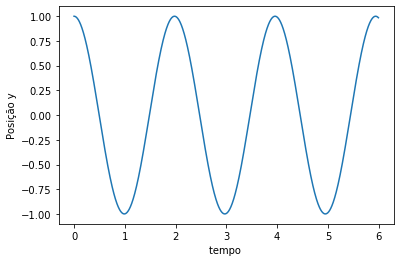

In [74]:
psi = np.sin(np.pi*x)
phi = np.zeros(N1,float)
phi1 = np.zeros(N1,float)
psi1 = np.zeros(N1,float)
temp = np.arange(0,6,0.005) 
data = np.zeros(len(temp),float)
data[0] = psi[49]
t = 0
for i in range(1,len(temp)):
    while t < temp[i]:
        erro = 1e-6
        e = 1
        b1 = np.dot(B,psi[1:-1]) + h*phi[1:-1]
        b2 = np.dot(B,phi[1:-1]) + np.dot(C,psi[1:-1])
        while np.abs(e) > erro:
            psi1[1:-1] = 1/a1*(b1- np.dot(A,psi[1:-1]))
            phi1[1:-1] = 1/a1*(b2- np.dot(A,phi[1:-1]))
            e = np.sum(psi1**2-psi**2)
            psi = np.copy(psi1)
            phi = np.copy(phi1)
        t += h
        data[i] = psi[49] 
p.plot(temp,data)
p.xlabel('tempo ')
p.ylabel('Posição y')
p.show()

## Alínea 2

Ao usar o método Gauss-Seidel para n dimensões, precisamos de iterar por n vezes mais equações do que para uma dimensão, o que pode comprometer a eficiência do método. No caso das matrizes LU, precisamos também de resolver n vezes mais sistemas, porém, visto que as matrizes são determinadas de uma só vez e não as precisamos de recalcular, e tendo também em conta que a eliminação de Gauss é bastante rápida com esta decomposição, este método acaba por ser mais eficaz.

## Alínea 4

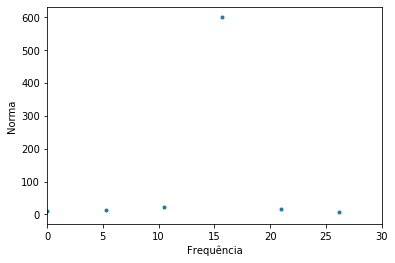

In [81]:
trans = npf.rfft(data)
omega = 2*np.pi/(len(data))/h*np.arange(0,(len(data)+1)/2,1)
p.plot(omega,np.abs(trans),'.')
p.xlim(0,30)
p.xlabel('Frequência')
p.ylabel('Norma')
p.show()


Podemos ver que, por se tratar de uma função sinusoidal, existe apenas um ponto diferente de 0 na transformada de Fourier, que corresponde à frequência do sinal. Nisto, a frequência é escrita como:

$\omega  = \frac{2\pi}{N\Delta t}k $,

onde $N$ é o número de pontos da amostragem e $\Delta t$ corresponde ao intervalo de tempo entre medições, que neste caso coincide com o nosso $h$. Por causa disto, precisamos de ter cuidado com as nossas escolhas do $ N $ e do $\Delta t$: Numa mesma amostragem, se aumentarmos um, o outro deve obrigatoriamente diminuir, caso contrário a nossa frequência varia, o que não pode acontecer por estarmos a estudar a mesma amostragem. Para além disto, ao escolhermos um N baixo, podemos não apanhar zonas de interesse da nossa função e, inclusive, não ver periodicidade (ao estudarmos uma onda sinusoidal, por exemplo, podemos escolher N tal que os pontos medidos calhem sempre na mesma amplitude, resultando por isso numa reta, que tem uma periodicidade bem diferente da da onda que pretendemos estudar).

## Alínea 5

In [4]:
a = 0.01
delta = 0.1
sigma = 1.95                            ## <---- corresponde ao 'a' que está no enunciado.
N1 = int(1/a)
N = N1 - 2
h = delta*a
x = np.linspace(0,1,N1)
c = np.sqrt(1+sigma*(x[1:-1]-0.5))
a1 = 1+(c*h)**2/(a**2)/2
a2 = -(c*h)**2/(4*a**2)
b1 = 1-(c*h)**2/(a**2)/2
b2 = -a2
c1 = -2*c**2*h/a**2
c2 = c**2*h/a**2
A = np.copy(matriz(np.zeros(len(a2)),a2))
B = np.copy(matriz(b1,b2))
C = np.copy(matriz(c1,c2))


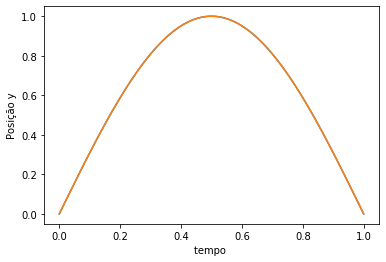

In [10]:
psi = np.sin(np.pi*x)
p.plot(x,psi)
phi = np.zeros(N1,float)
phi1 = np.zeros(N1,float)
psi1 = np.zeros(N1,float)
temp = np.arange(0,6,0.05) 
data1 = np.zeros(len(temp),float)
data1[0] = psi[49]
t = 0
MA = np.zeros((len(temp),len(x)),float)
for i in range(1,len(temp)):
    while t < temp[i]:
        erro = 1e-6
        e = 1
        b1 = np.dot(B,psi[1:-1]) + h*phi[1:-1]
        b2 = np.dot(B,phi[1:-1]) + np.dot(C,psi[1:-1])
        while np.abs(e) > erro:
            psi1[1:-1] = 1/a1*(b1- np.dot(A,psi[1:-1]))
            phi1[1:-1] = 1/a1*(b2- np.dot(A,phi[1:-1]))
            e = np.sum(psi1**2-psi**2)
            psi = np.copy(psi1)
            phi = np.copy(phi1)
        t += h
        data1[i] = psi[49] 
    MA[i] = psi
#p.plot(temp,data1)
p.xlabel('tempo ')
p.ylabel('Posição y')
p.show()

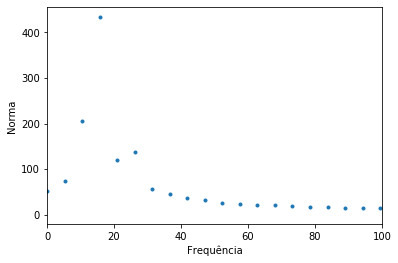

In [82]:
trans1 = npf.rfft(data1)
omega = 2*np.pi/(len(data1))/h*np.arange(0,(len(data1)+1)/2,1)
p.plot(omega,np.abs(trans1),'.')
p.xlabel('Frequência')
p.ylabel('Norma')
p.xlim(0,100)
p.show()

Neste caso, vemos que a onda não é um harmónico perfeito, e por isso será uma sobreposição de ondas sinusoidais com diferentes frequências. Nisto, podemos na mesma reparar que existe uma frequência dominante, e que por isso conseguimos notar ainda alguma periodicidade na função. Isto deve-se ao facto de introduzirmos um $c$ (velocidade da onda) que depende da posição, o que corresponde também a dizer que o meio onde a onda se propaga tem uma densidade variável com a posição, tornando a oscilação e propagação da onda mais difícil nuns sítios do que noutros. Já no outro caso, tendo uma densidade constante na posição, a onda que estudamos trata-se de um modo normal de vibração, o que justifica o porquê da posição de $\psi(0.5,t)$ em função do tempo resultar numa função sinusoidal. 